In [1]:
# import the necessary libraries
import numpy as np 
import pandas as pd 
import os

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pycountry
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from pywaffle import Waffle
import json,plotly
py.init_notebook_mode(connected=True)
import folium 
from folium import plugins
plt.style.use("fivethirtyeight")# for pretty graphs

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
#plt.rcParams['image.cmap'] = 'viridis'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the datasets

df= pd.read_csv('coronavirus-cases-in-india/Covid-cases-in-India.csv')
df_india = df.copy()

# Coordinates of India States and Uts
India_coord = pd.read_excel('coronavirus-cases-in-india/Indian Coordinates.xlsx')

#Day by day data of India, Korea and Italy
dbd_India = pd.read_excel('coronavirus-cases-in-india/per_day_cases.xlsx',sheet_name='India')
dbd_Italy = pd.read_excel('coronavirus-cases-in-india/per_day_cases.xlsx',sheet_name="Italy")
dbd_Korea = pd.read_excel('coronavirus-cases-in-india/per_day_cases.xlsx',sheet_name="Korea")



In [3]:
df.drop(['S. No.'],axis=1,inplace=True)
df['Total cases'] = df['Total Confirmed cases (Indian National)'] + df['Total Confirmed cases ( Foreign National )'] 
df['Active cases'] = df['Total cases'] - (df['Cured/Discharged/Migrated'] + df['Deaths'])
print(f'Total number of Confirmed COVID 2019 cases across India:', df['Total cases'].sum())
print(f'Total number of Active COVID 2019 cases across India:', df['Active cases'].sum())
print(f'Total number of Cured/Discharged/Migrated COVID 2019 cases across India:', df['Cured/Discharged/Migrated'].sum())
print(f'Total number of Deaths due to COVID 2019  across India:', df['Deaths'].sum())
print(f'Total number of States/UTs affected:', len(df['Name of State / UT']))

Total number of Confirmed COVID 2019 cases across India: 223
Total number of Active COVID 2019 cases across India: 196
Total number of Cured/Discharged/Migrated COVID 2019 cases across India: 23
Total number of Deaths due to COVID 2019  across India: 4
Total number of States/UTs affected: 20


In [4]:

#https://www.kaggle.com/nxrprime/styling-data-frames-covid-19-vs-conferences
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: pink' if v else '' for v in is_max]



#df.style.apply(highlight_max,subset=['Total Confirmed cases (Indian National)', 'Total Confirmed cases ( Foreign National )'])
df.style.apply(highlight_max,subset=['Cured/Discharged/Migrated', 'Deaths','Total cases','Active cases'])



,Name of State / UT,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Deaths,Total cases,Active cases
0,Andhra Pradesh,3,0,0,0,3,3
1,Chattisgarh,1,0,0,0,1,1
2,Delhi,16,1,5,1,17,11
3,Gujarat,5,0,0,0,5,5
4,Haryana,3,14,0,0,17,17
5,Karnataka,15,0,1,1,15,13
6,Kerala,26,2,3,0,28,25
7,Maharashtra,49,3,0,1,52,51
8,Odisha,2,0,0,0,2,2
9,Pondicherry,1,0,0,0,1,1


In [5]:


x = df.groupby('Name of State / UT')['Active cases'].sum().sort_values(ascending=False).to_frame()
x = x.style.background_gradient(cmap='Reds')

total_state_wise = x
total_state_wise

,Active cases
Name of State / UT,
Maharashtra,51
Kerala,25
Haryana,17
Telengana,16
Uttar Pradesh,14
Rajasthan,14
Karnataka,13
Delhi,11
Union Territory of Ladakh,10


In [6]:
fig = px.bar(df.sort_values('Active cases', ascending=False).sort_values('Active cases', ascending=True), 
             x="Active cases", y="Name of State / UT", 
             title='Total Active Cases', 
             text='Active cases', 
             orientation='h', 
             width=1000, height=1000, range_x = [0, max(df['Active cases'])])
fig.update_traces(marker_color='#467dcf', opacity=0.8, textposition='inside')

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

total_active_cases = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

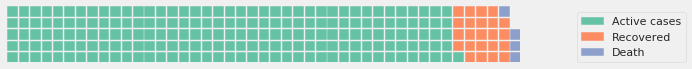

In [7]:
df_condensed = pd.DataFrame([df['Active cases'].sum(),df['Cured/Discharged/Migrated'].sum(),df['Deaths'].sum()],columns=['Cases'])
df_condensed.index=['Active cases','Recovered','Death']
df_condensed


fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    values=df_condensed['Cases'],
    labels=list(df_condensed.index),
    figsize=(10, 3),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)

In [8]:
# create map and display it

df_full = pd.merge(India_coord,df,on='Name of State / UT')
map = folium.Map(location=[20, 80], zoom_start=3.5,tiles='Stamen Toner')

for lat, lon, value, name in zip(df_full['Latitude'], df_full['Longitude'], df_full['Active cases'], df_full['Name of State / UT']):
    folium.CircleMarker([lat, lon],
                        radius=value*0.7,
                        popup = ('<strong>State</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Active Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.3 ).add_to(map)
map



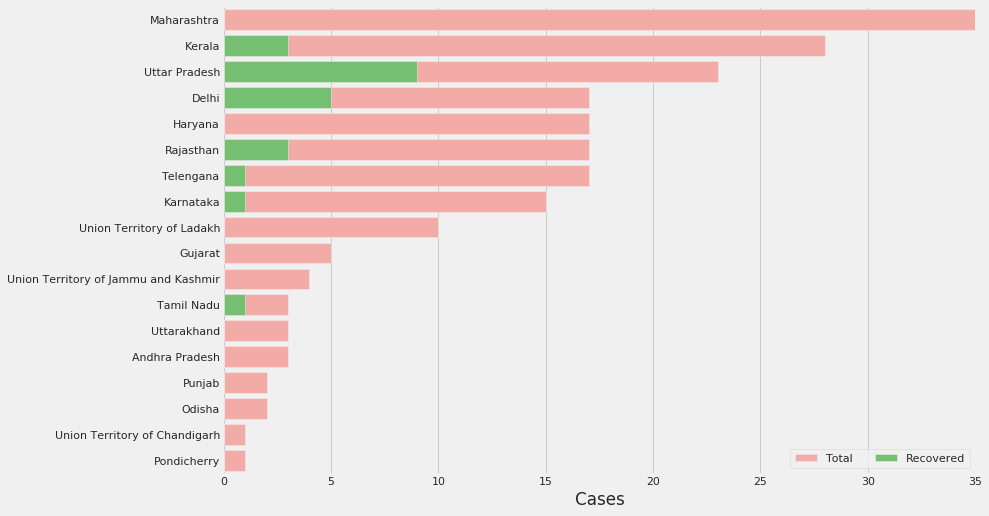

In [9]:


f, ax = plt.subplots(figsize=(12, 8))
data = df_full[['Name of State / UT','Total cases','Cured/Discharged/Migrated','Deaths']]
data.sort_values('Total cases',ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x="Total cases", y="Name of State / UT", data=data,
            label="Total", color="r")

sns.set_color_codes("muted")
sns.barplot(x="Cured/Discharged/Migrated", y="Name of State / UT", data=data,
            label="Recovered", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 35), ylabel="",
       xlabel="Cases")
sns.despine(left=True, bottom=True)

In [10]:
# Rise in COVID-19 cases in India
fig = go.Figure()
fig.add_trace(go.Scatter(x=dbd_India['Date'], y=dbd_India['Total Cases'],
                    mode='lines+markers',name='Total Cases'))

fig.add_trace(go.Scatter(x=dbd_India['Date'], y=dbd_India['Recovered'], 
                mode='lines',name='Recovered'))
fig.add_trace(go.Scatter(x=dbd_India['Date'], y=dbd_India['Active'], 
                mode='lines',name='Active'))
fig.add_trace(go.Scatter(x=dbd_India['Date'], y=dbd_India['Deaths'], 
                mode='lines',name='Deaths'))
        
    
fig.update_layout(title_text='Trend of Coronavirus Cases in India(Cumulative cases)',plot_bgcolor='rgb(250, 242, 242)')

fig.show()

trends = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)
# New COVID-19 cases reported daily in India

import plotly.express as px
fig = px.bar(dbd_India, x="Date", y="New Cases", barmode='group',
             height=400)
fig.update_layout(title_text='New Coronavirus Cases in India per day',plot_bgcolor='rgb(250, 242, 242)')

fig.show()
new_cases_per_day = map_html = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

In [ ]:
from flask import Flask,render_template
app = Flask(__name__)
@app.route('/')
def index():

    return render_template('index.html', plot1=total_active_cases,plot2 = trends, plot3 = new_cases_per_day)

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
